# LA-ICP-MS dataset processing
## required packets

In [1]:
from process_image import *

## basic settings
set some basic infos for the image procesing

In [2]:
settings = getBaseSettings()

# show debugging output
settings["showDebuggingOutput"] = True
# set the physical spot distance in µm
settings["spot_distance_x"]     = 7.0
# set the physical spot distance in µm
settings["spot_distance_y"]     = 0.579150579150579

# change interpolation between the lines in x direction [integer, 0 disables this option]
settings["stretch_x"]           = 6
# set the gaussian filter size in y direction [integer, 0 disables this option]
settings["smooth_y"]            = 3

## set the data source
select the datasource - if load_raw = True, the script expects a path to the raw dataset consisting of multiple *.xl files. Else, the script expects an excel file with multiple sheets.

If no `workingDirectory` or `excel_file` is set, the script opens a file dialog.


In [3]:
settings["load_raw"]     = True
settings["workingDirectory"] = settings["home_dir"] + os.sep + "example_data" + os.sep + "raw format" + os.sep

settings["load_raw"]   = False
settings["excel_file"] = settings["home_dir"] + os.sep + "example_data" + os.sep + "excel_example.xlsx"

In [4]:
laser_data = LA_ICP_MS_LOADER(settings)

Selected working directory: E:\GIT\LA-ICP-MS\example_data\raw format\
loaded a dataset with the dimensions of 50 x 519 datapoints and 11 elements:
['²³Na', '²⁴Mg', '²⁷Al', '³⁹K', '⁴⁷Ti', '⁵¹V', '⁵²Cr', '⁵⁵Mn', '⁶⁶Zn', '⁸⁷Rb', '¹³⁷Ba']


# set calibration data if available

this dictionary requires the calibration factor for ppm in [signal / ppm]

Since the oxide form of every element has to be known, there is only a limited amount of known elements:

In [5]:
print('Known elements for calibration: ')
s = ''
for element in laser_data.oxide_dict: s += element+', '
print( s )


Known elements for calibration: 
Na, Mg, Al, K, Ti, V, Cr, Mn, Zn, Rb, Ba, Ca, Sr, P, Cu, Ni, Pb, As, 


In [6]:
calibration_area_2 = {
    "Na23":   1.171,
    "Mg24":   3.953,
    "Al27":   2.711,
    "K39":    9.495,
    "Ti47":   0.488,
    "V51":    5.701,
    "Cr52":   4.876,
    "Mn55":   5.554,
    "Zn66":   0.527,
    "Rb87":  18.741,
    "Ba137":  0.391
}

calibration_area_3 = {
    "Na23":   2.502,
    "Mg24":   6.373,
    "Al27":   4.361,
    "K39":    8.945,
    "Ti47":   0.796,
    "V51":    8.401,
    "Cr52":   5.959,
    "Mn55":  10.281,
    "Zn66":   0.801,
    "Rb87":  27.477,
    "Ba137":  0.771
}

laser_data.set_calibration_dictionary( calibration_area_2 )

# show an example image (first element in the set)

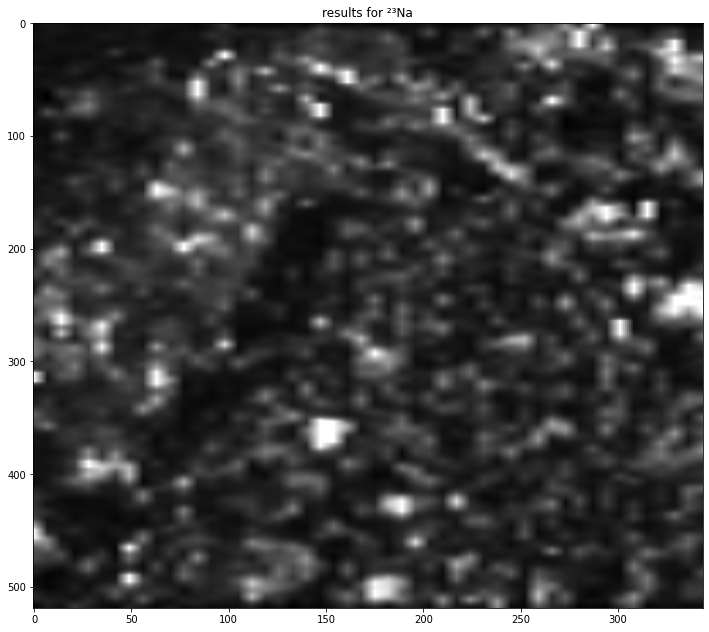

In [7]:
laser_data.show_single_image( )

## show in the napari viewer
A new window will open. Cell execution will continue in between.

In [8]:
selected_elements = ['Na23', 'Rb85', 'Ti47']
laser_data.show_image_set() # selected_elements

## saving images
uncomment the following line if the results should be saved

In [9]:
# laser_data.save_images()

# experiments with superpixels for segmentation
the following code is work in progress!

In [10]:
import cv2
import time
import matplotlib.pyplot as plt
from skimage.filters import sobel, threshold_multiotsu
from skimage.segmentation import felzenszwalb, slic, watershed, mark_boundaries
from skimage import color
from matplotlib.colors import LinearSegmentedColormap
import napari
from molmass import Formula as form

In [11]:
element = laser_data.get_first_element()
def process_SLIC_of_element(element, multi_otsu_class_cnt = 4):
    img, _ = laser_data.optimize_img( laser_data.images[element] )

    img_8bit = img * 255
    img_8bit = img_8bit.astype(np.uint8)
    denoised = cv2.fastNlMeansDenoising( img_8bit, 13, 19, 35 )

    #from skimage.future import graph

    segments_slic = slic(denoised, n_segments=330, compactness=0.15, sigma=1,
                        start_label=1)

    mean_slic = color.rgb2gray( color.label2rgb(segments_slic, img, kind='avg', bg_label=0) )
    
    # Show the segmentations.
    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(18, 7), sharex=True, sharey=True)
    ax = axes.ravel()
    cmap = laser_data.get_color_by_element(element, napari_cmap=False)

    thresholds = threshold_multiotsu(mean_slic, classes=multi_otsu_class_cnt)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(mean_slic, bins=thresholds)

    #colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
    #cmap = LinearSegmentedColormap.from_list(
    #        "Custom", colors, N=256)

    ax[0].imshow(img, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
    ax[0].set_title('Image [{}]'.format(laser_data.elements[element]))

    ax[1].imshow(denoised, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
    ax[1].set_title('denoised')

    ax[2].imshow(mark_boundaries(img, segments_slic), aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None) #
    ax[2].set_title('SLIC superpixels')

    ax[3].imshow(mean_slic, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None);
    ax[3].set_title('mean values in slic')

    ax[4].imshow(regions, aspect=laser_data.spot_distance_y/laser_data.spot_distance_x, cmap=cmap, interpolation=None)
    ax[4].set_title('multi-otsu ({}x)'.format(multi_otsu_class_cnt))

    for a in ax:
        a.axis('off')
    fig.tight_layout()
    plt.show()
    """
    _ = plt.hist(img_8bit.flatten(), bins='auto')  # arguments are passed to np.histogram
    plt.show()
    _ = plt.hist(out1.flatten(), bins='auto')  # arguments are passed to np.histogram
    plt.show()
    """
    
    return denoised, segments_slic, mean_slic, regions


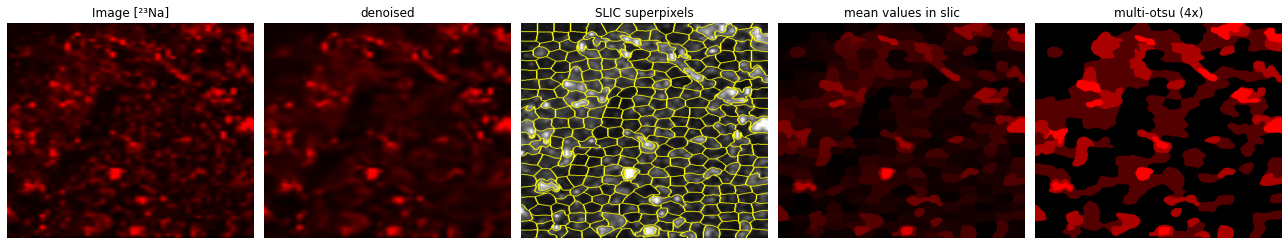

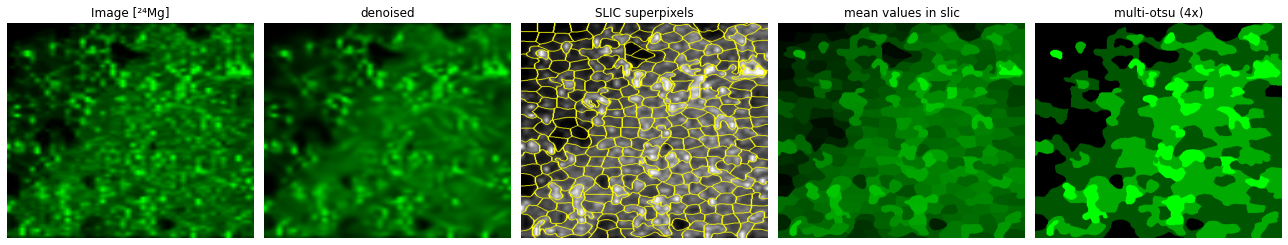

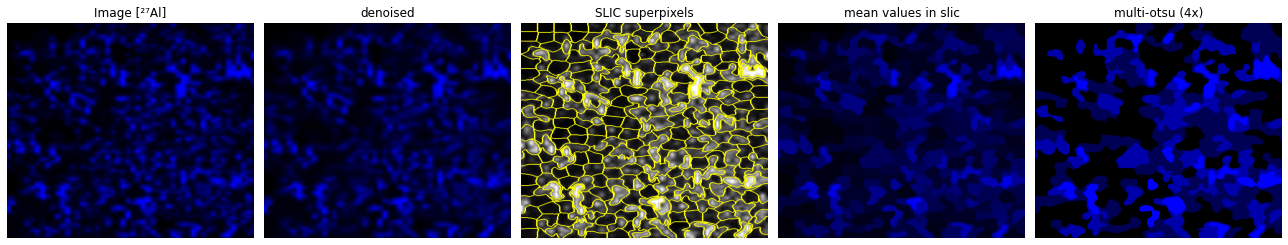

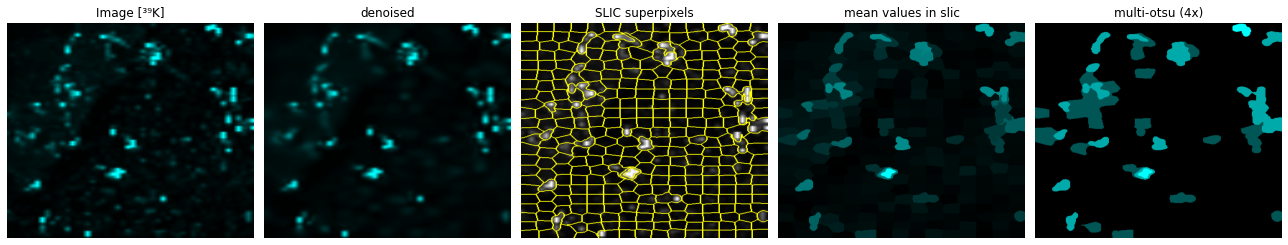

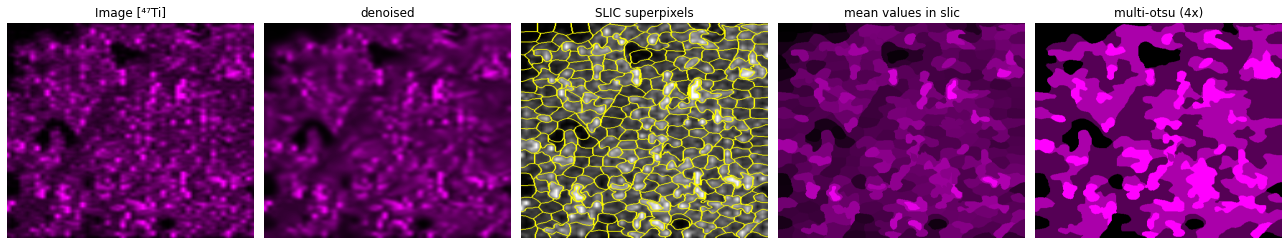

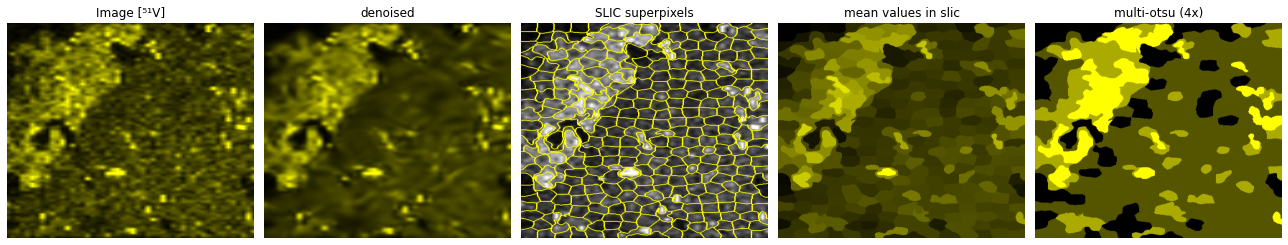

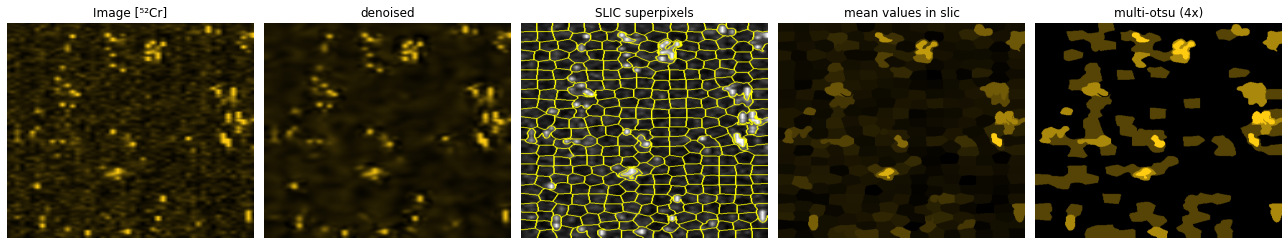

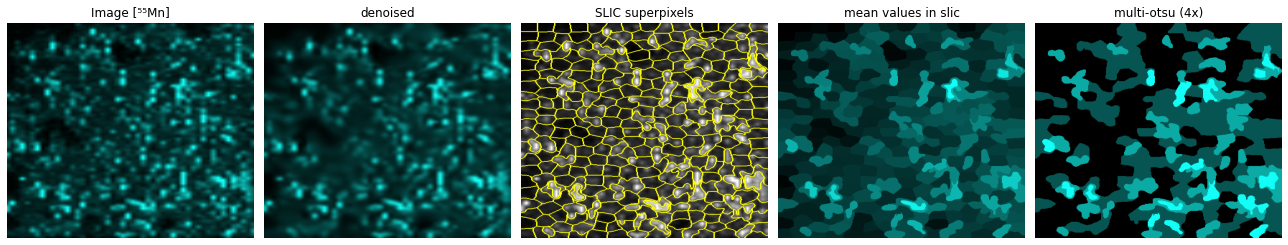

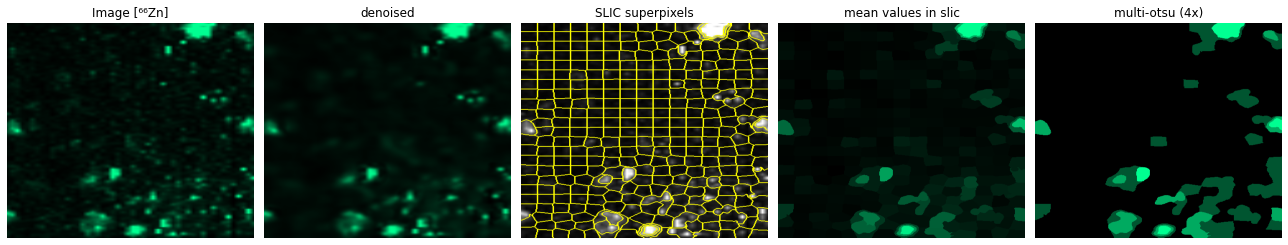

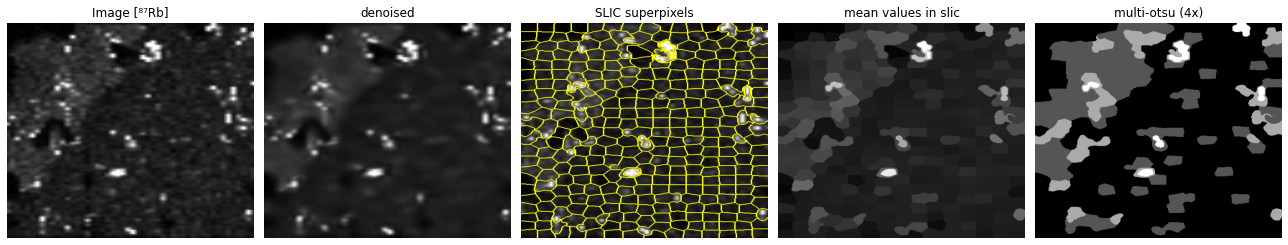

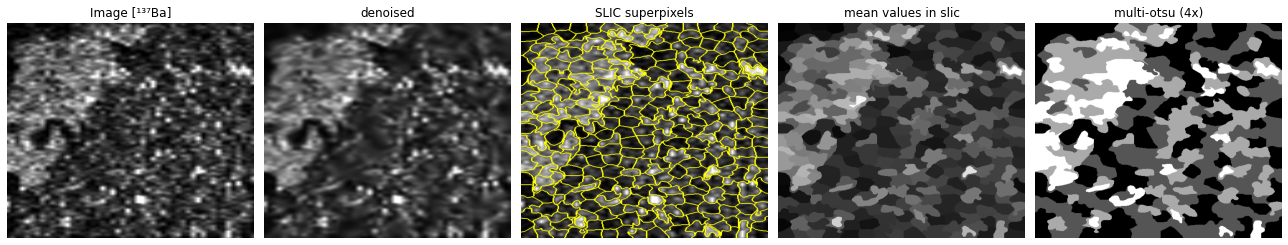

In [12]:
denoised_dict = {}
segments_slic_dict = {}
mean_slic_dict = {}
regions_dict = {}
for element in laser_data.elements.keys():
    denoised_dict[element], segments_slic_dict[element], mean_slic_dict[element], regions_dict[element] = process_SLIC_of_element(element)


In [13]:
regions_dict

viewer = napari.Viewer()
new_layer = viewer.add_image(denoised_dict[element], name='LA-ICP-MS [{}]'.format(laser_data.elements[element]), scale=laser_data.scaling, colormap=laser_data.get_color_by_element(element), rendering="iso")
labels_layer = viewer.add_labels(regions_dict[element], name='segmentation for {}'.format(laser_data.elements[element]), scale=laser_data.scaling)

In [14]:
"""
# mpo = mass-%-oxide
calibration_area_2 = {
    "Na23": {'mpo':   8683.914, 'ppm':  1.171},
    "Mg24": {'mpo':  23835.116, 'ppm':  3.953},
    "Al27": {'mpo':  14349.798, 'ppm':  2.711},
    "K39":  {'mpo':  78820.324, 'ppm':  9.495},
    "Ti47": {'mpo':   2923.188, 'ppm':  0.488},
    "V51":  {'mpo':  31937.183, 'ppm':  5.701},
    "Cr52": {'mpo':  33360.189, 'ppm':  4.876},
    "Mn55": {'mpo':  43010.588, 'ppm':  5.554},
    "Zn66": {'mpo':   4230.290, 'ppm':  0.527},
    "Rb87": {'mpo': 157868.805, 'ppm': 18.741},
    "Ba137":{'mpo':   3505.525, 'ppm':  0.391}
}
calibration_area_3 = {
    "Na23": {'mpo':  18559.990, 'ppm':  2.502},
    "Mg24": {'mpo':  38431.882, 'ppm':  6.373},
    "Al27": {'mpo':  23078.091, 'ppm':  4.361},
    "K39":  {'mpo':  74258.320, 'ppm':  8.945},
    "Ti47": {'mpo':   4770.334, 'ppm':  0.796},
    "V51":  {'mpo':  47057.691, 'ppm':  8.401},
    "Cr52": {'mpo':  40771.331, 'ppm':  5.959},
    "Mn55": {'mpo':  79623.680, 'ppm': 10.281},
    "Zn66": {'mpo':   6433.280, 'ppm':  0.801},
    "Rb87": {'mpo': 231460.856, 'ppm': 27.477},
    "Ba137":{'mpo':   6907.159, 'ppm':  0.771}
}
"""
print()

In [24]:
def summarize_calibrated_statistics( element, cal_dict, labels_layer, region_id = 0 ):
    area = 0.0
    sum_ppm_selected = 0.0
    mean_mpo_selected = 0.0
    #selected_layer = labels_layer.data.max() #3 <- always get the umpmost layer
    mask_selected = np.where(labels_layer.data == region_id, 1, 0) # binary mask of the selection layer
    sum_pixel_selected = mask_selected.sum() # amount of segmented pixels in the binary mask
    if sum_pixel_selected > 0:
        cal_img_ppm, cal_img_mpo = laser_data.get_calibrated_images(element)

        area = laser_data.pixel_area * sum_pixel_selected

        concentration_in_selection = cal_img_ppm*labels_layer.data

        sum_ppm_selected = concentration_in_selection.sum()
        mean_mpo_selected = (cal_img_mpo*mask_selected).sum() / sum_pixel_selected

        """
        print('-'*20)
        print('Concentration of {} in the selected area ({:.1f} {}² / {} px)'.format(laser_data.elements[element], area, laser_data.unit, sum_pixel_selected ))
        print('   sum:            {:.1f} {}'.format(sum_ppm_selected, 'ppm'))
        #print('   sum per area:   {:.1f} {}/{}²'.format(sum_pixel_selected*pixel_area, 'ppm', unit))
        print(element)
        print(get_element_from_isotope( element ))
        print(laser_data.oxide_dict[get_element_from_isotope( element )])

        print('   mean m-% oxide: {:.6f} m.-%/px (calculated as {})'.format(mean_mpo_selected, laser_data.oxide_dict[get_element_from_isotope( element )]))
        print()
        """
    return sum_pixel_selected, area, sum_ppm_selected, mean_mpo_selected


In [25]:
result = [['region id', 'element', 'selected pixel', 'selected area', 'selected ppm', 'm.-%/px']]
for region_id in range(labels_layer.data.max()):
    for element in laser_data.elements.keys():
        sum_pixel_selected, area, sum_ppm_selected, mean_mpo_selected = summarize_calibrated_statistics( element, calibration_area_2, labels_layer, region_id )
        result_line = [region_id, element, sum_pixel_selected, area, sum_ppm_selected, mean_mpo_selected]
        result.append(result_line)

In [26]:
pos = 0
for result_line in result:
    if result_line[0] != pos:
        pos = result_line[0]
        print('-'*20)
    print(result_line)

--------------------
['region id', 'element', 'selected pixel', 'selected area', 'selected ppm', 'm.-%/px']
--------------------
[0, 'Na23', 57451, 33272.77992277991, 705932305.2153226, 0.3375980458837642]
[0, 'Mg24', 57451, 33272.77992277991, 1829709105.0919733, 1.1141241792832652]
[0, 'Al27', 57451, 33272.77992277991, 6194580658.380671, 3.0891035319888047]
[0, 'K39', 57451, 33272.77992277991, 2219809576.405176, 0.9000702423934578]
[0, 'Ti47', 57451, 33272.77992277991, 326594290.380562, 0.19265028072704254]
[0, 'V51', 57451, 33272.77992277991, 13384380.033578068, 0.007002643762044867]
[0, 'Cr52', 57451, 33272.77992277991, 24818785.22618071, 0.018080486373678147]
[0, 'Mn55', 57451, 33272.77992277991, 60311769.82097845, 0.037355557306572744]
[0, 'Zn66', 57451, 33272.77992277991, 56433500.66684738, 0.04812418743939483]
[0, 'Rb87', 57451, 33272.77992277991, 4749024.235633103, 0.0017055869365269717]
[0, 'Ba137', 57451, 33272.77992277991, 60134774.27475336, 0.010147386220624003]
-----------